In [1]:
# Import library yang diperlukan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns


In [2]:

# === Data Loading ===
data = []
labels = []
file_name = []
dataset_path = "Dataset/"  # Path ke folder dataset
class_names = ['DefectFree', 'DefectHoles', 'DefectLines', 'DefectStain']

for sub_folder in class_names:
    sub_folder_path = os.path.join(dataset_path, sub_folder)
    if not os.path.exists(sub_folder_path):
        print(f"Folder {sub_folder_path} tidak ditemukan!")
        continue
    sub_folder_files = os.listdir(sub_folder_path)
    for filename in sub_folder_files:
        img_path = os.path.join(sub_folder_path, filename)
        img = cv.imread(img_path)
        if img is None:
            print(f"Gagal memuat gambar: {img_path}")
            continue
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        data.append(img)
        labels.append(sub_folder)
        file_name.append(filename)
data = np.array(data, dtype=object)  # Gunakan dtype=object untuk ukuran gambar yang bervariasi
labels = np.array(labels)
file_name = np.array(file_name)


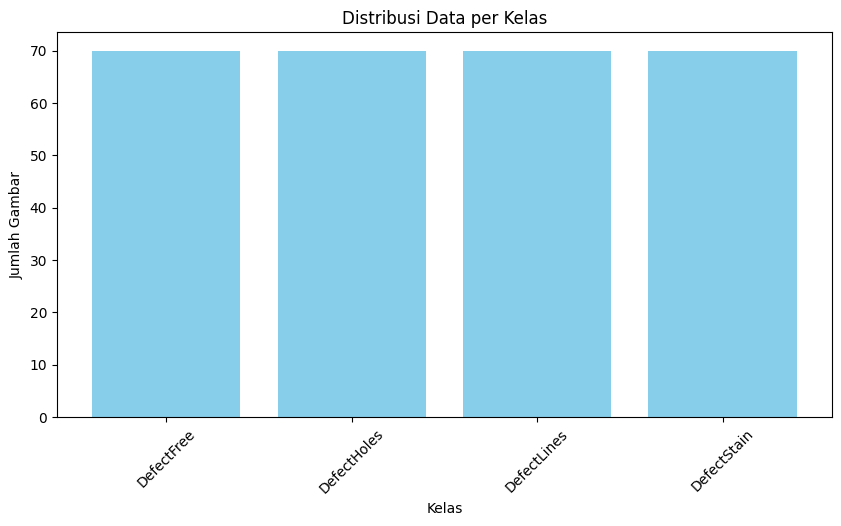

In [3]:

# === Data Understanding ===
# Menampilkan jumlah data per kelas
unique_labels, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(10, 5))
plt.bar(unique_labels, counts, color='skyblue')
plt.title("Distribusi Data per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.savefig('class_distribution3.png')


Jumlah total data: 280
Kelas: ['DefectFree' 'DefectHoles' 'DefectLines' 'DefectStain']
Jumlah per kelas: {np.str_('DefectFree'): np.int64(70), np.str_('DefectHoles'): np.int64(70), np.str_('DefectLines'): np.int64(70), np.str_('DefectStain'): np.int64(70)}


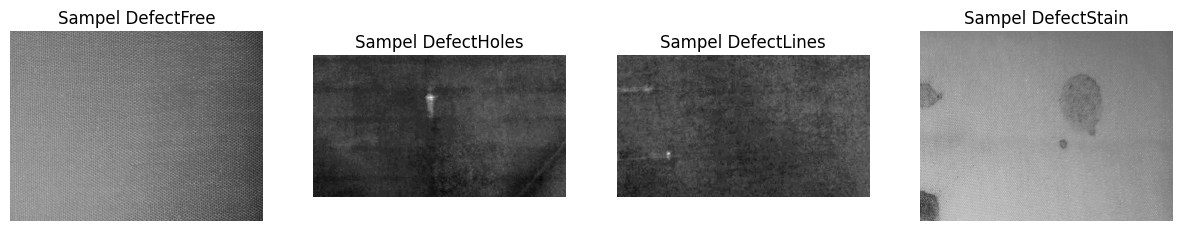

In [4]:

# Menampilkan sampel gambar dari setiap kelas
plt.figure(figsize=(15, 5))
for i, label in enumerate(unique_labels):
    idx = np.where(labels == label)[0][0]
    plt.subplot(1, 4, i+1)
    plt.imshow(data[idx], cmap='gray')
    plt.title(f"Sampel {label}")
    plt.axis('off')
plt.savefig('sample_images3.png')

print(f"Jumlah total data: {len(data)}")
print(f"Kelas: {unique_labels}")
print(f"Jumlah per kelas: {dict(zip(unique_labels, counts))}")


In [5]:

# === Data Augmentation ===
# Augmentasi hanya dilakukan jika jumlah data per kelas < 100
data_augmented = []
labels_augmented = []
file_name_augmented = []
for i in range(len(data)):
    img = data[i]
    label = labels[i]
    fname = file_name[i]
    
    # Original image
    data_augmented.append(img)
    labels_augmented.append(label)
    file_name_augmented.append(fname)
    
    # Augmentasi: rotasi 90 derajat jika jumlah data per kelas < 100
    if counts[np.where(unique_labels == label)[0][0]] < 100:
        rotated = cv.rotate(img, cv.ROTATE_90_CLOCKWISE)
        data_augmented.append(rotated)
        labels_augmented.append(label)
        file_name_augmented.append(f"rot90_{fname}")

data_augmented = np.array(data_augmented, dtype=object)
labels_augmented = np.array(labels_augmented)
file_name_augmented = np.array(file_name_augmented)
print(f"Data sebelum augmentasi: {len(data)}")
print(f"Data setelah augmentasi: {len(data_augmented)}")


Data sebelum augmentasi: 280
Data setelah augmentasi: 560


In [ ]:
def resize(image, target_size=(100, 100)):
    return cv.resize(image, target_size, interpolation=cv.INTER_AREA)

def histogram_equalization(image):
    return cv.equalizeHist(image)

def adaptive_thresholding(image):
    return cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)

def opening(image):
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5)) 
    return cv.morphologyEx(image, cv.MORPH_OPEN, kernel)

def sobel_edge_detection(image):
    sobel_x = cv.Sobel(image, cv.CV_64F, 1, 0, ksize=3)
    sobel_y = cv.Sobel(image, cv.CV_64F, 0, 1, ksize=3)
    sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    return cv.normalize(sobel, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)

data_preprocessed = []
for img in data_augmented:
    try:
        img_resized = resize(img)
        img_equalized = histogram_equalization(img_resized)
        img_thresholded = adaptive_thresholding(img_equalized)
        img_opened = opening(img_thresholded)
        img_edges = sobel_edge_detection(img_opened)
        data_preprocessed.append(img_edges)
    except Exception as e:
        print(f"Error saat preprocessing: {e}")
        continue
data_preprocessed = np.array(data_preprocessed, dtype=np.uint8)

print(f"Data setelah preprocessing: {len(data_preprocessed)}")
if len(data_preprocessed) == 0:
    raise ValueError("Data preprocessing kosong! Periksa fungsi preprocessing.")

Data setelah preprocessing: 560


In [7]:

# === Feature Extraction ===
def glcm(image, derajat, distance=2):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of: 0, 45, 90, 135.")
    glcm = graycomatrix(image, [distance], angles, 256, symmetric=True, normed=True)
    return glcm

def correlation(matriks):
    return graycoprops(matriks, 'correlation')[0, 0]

def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

def homogeneity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

def entropy_glcm(matriks):
    return entropy(matriks.ravel())


In [8]:

# Ekstraksi fitur GLCM
Derajat0, Derajat45, Derajat90, Derajat135 = [], [], [], []
for img in data_preprocessed:
    D0 = glcm(img, 0, distance=1)
    D45 = glcm(img, 45, distance=1)
    D90 = glcm(img, 90, distance=1)
    D135 = glcm(img, 135, distance=1)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)


In [9]:

# Inisialisasi list untuk fitur
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
Dissimilarity0, Dissimilarity45, Dissimilarity90, Dissimilarity135 = [], [], [], []
Homogeneity0, Homogeneity45, Homogeneity90, Homogeneity135 = [], [], [], []
Entropy0, Entropy45, Entropy90, Entropy135 = [], [], [], []
ASM0, ASM45, ASM90, ASM135 = [], [], [], []
Energy0, Energy45, Energy90, Energy135 = [], [], [], []
Correlation0, Correlation45, Correlation90, Correlation135 = [], [], [], []


In [10]:

# Hitung fitur untuk setiap sudut
for i in range(len(data_preprocessed)):
    Kontras0.append(contrast(Derajat0[i]))
    Kontras45.append(contrast(Derajat45[i]))
    Kontras90.append(contrast(Derajat90[i]))
    Kontras135.append(contrast(Derajat135[i]))
    
    Dissimilarity0.append(dissimilarity(Derajat0[i]))
    Dissimilarity45.append(dissimilarity(Derajat45[i]))
    Dissimilarity90.append(dissimilarity(Derajat90[i]))
    Dissimilarity135.append(dissimilarity(Derajat135[i]))
    
    Homogeneity0.append(homogeneity(Derajat0[i]))
    Homogeneity45.append(homogeneity(Derajat45[i]))
    Homogeneity90.append(homogeneity(Derajat90[i]))
    Homogeneity135.append(homogeneity(Derajat135[i]))
    
    Entropy0.append(entropy_glcm(Derajat0[i]))
    Entropy45.append(entropy_glcm(Derajat45[i]))
    Entropy90.append(entropy_glcm(Derajat90[i]))
    Entropy135.append(entropy_glcm(Derajat135[i]))
    
    ASM0.append(ASM(Derajat0[i]))
    ASM45.append(ASM(Derajat45[i]))
    ASM90.append(ASM(Derajat90[i]))
    ASM135.append(ASM(Derajat135[i]))
    
    Energy0.append(energy(Derajat0[i]))
    Energy45.append(energy(Derajat45[i]))
    Energy90.append(energy(Derajat90[i]))
    Energy135.append(energy(Derajat135[i]))
    
    Correlation0.append(correlation(Derajat0[i]))
    Correlation45.append(correlation(Derajat45[i]))
    Correlation90.append(correlation(Derajat90[i]))
    Correlation135.append(correlation(Derajat135[i]))

# Simpan hasil ekstraksi ke CSV
data_table = {
    'Filename': file_name_augmented[:len(Kontras0)],
    'Label': labels_augmented[:len(Kontras0)],
    'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
    'Homogeneity0': Homogeneity0, 'Homogeneity45': Homogeneity45, 'Homogeneity90': Homogeneity90, 'Homogeneity135': Homogeneity135,
    'Dissimilarity0': Dissimilarity0, 'Dissimilarity45': Dissimilarity45, 'Dissimilarity90': Dissimilarity90, 'Dissimilarity135': Dissimilarity135,
    'Entropy0': Entropy0, 'Entropy45': Entropy45, 'Entropy90': Entropy90, 'Entropy135': Entropy135,
    'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
    'Energy0': Energy0, 'Energy45': Energy45, 'Energy90': Energy90, 'Energy135': Energy135,
    'Correlation0': Correlation0, 'Correlation45': Correlation45, 'Correlation90': Correlation90, 'Correlation135': Correlation135
}
df = pd.DataFrame(data_table)
df.to_csv('hasil_ekstraksi_3.csv', index=False)

hasil_ekstrak = pd.read_csv('hasil_ekstraksi_3.csv')
print(hasil_ekstrak.head())


       Filename       Label   Contrast0  Contrast45  Contrast90  Contrast135  \
0         1.jpg  DefectFree    0.000000    0.000000    0.000000     0.000000   
1   rot90_1.jpg  DefectFree    0.000000    0.000000    0.000000     0.000000   
2        10.jpg  DefectFree  216.216364  310.812162  135.959394   329.773493   
3  rot90_10.jpg  DefectFree  135.959394  329.773493  216.216364   310.812162   
4        11.jpg  DefectFree  100.798990  171.163147  147.344444   234.511785   

   Homogeneity0  Homogeneity45  Homogeneity90  Homogeneity135  ...     ASM90  \
0      1.000000       1.000000       1.000000        1.000000  ...  1.000000   
1      1.000000       1.000000       1.000000        1.000000  ...  1.000000   
2      0.992529       0.990924       0.993742        0.990616  ...  0.980715   
3      0.993742       0.990616       0.992529        0.990924  ...  0.979116   
4      0.995760       0.994800       0.994952        0.993880  ...  0.986717   

     ASM135   Energy0  Energy45  Energ

Fitur yang dipilih: Index(['Contrast0', 'Correlation0', 'Correlation45', 'Correlation90',
       'Correlation135'],
      dtype='object')


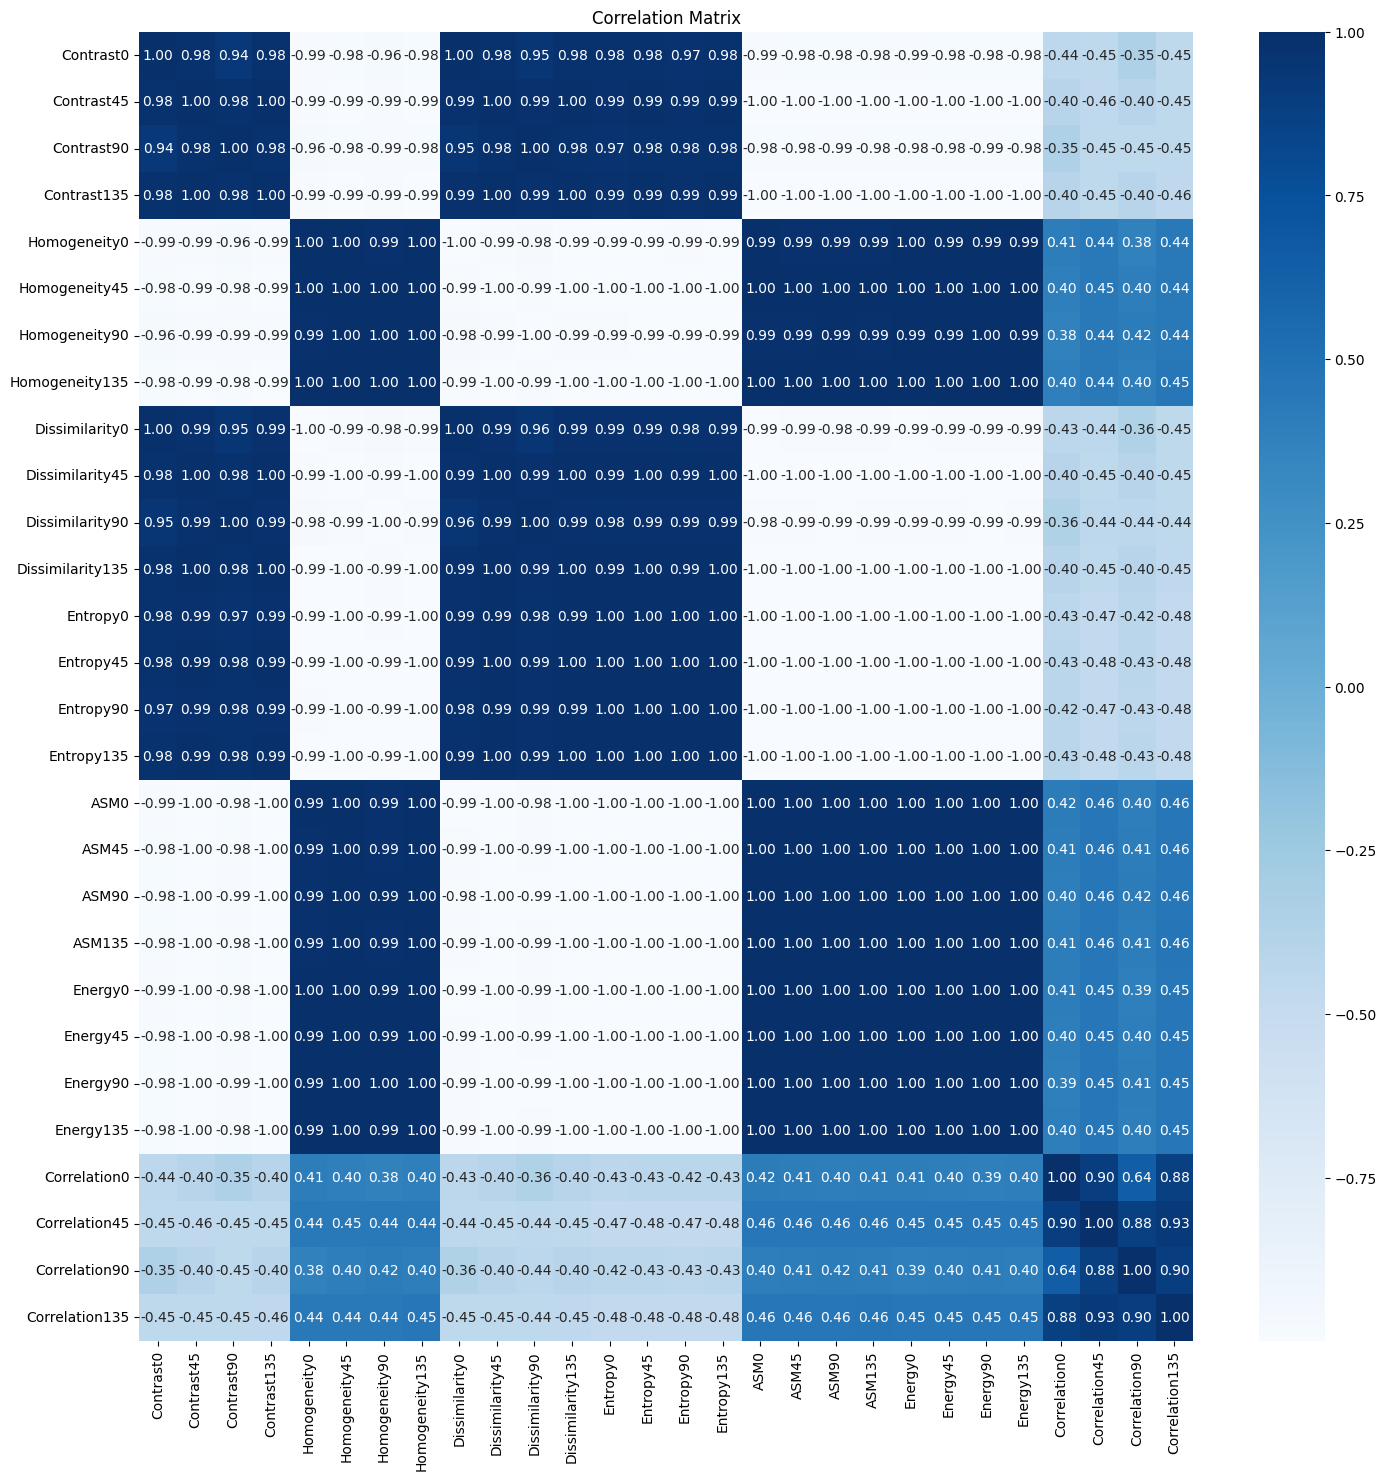

In [11]:

# === Feature Selection ===
# Menghitung korelasi
correlation = hasil_ekstrak.drop(columns=['Label', 'Filename']).corr()
plt.figure(figsize=(17, 17))
sns.heatmap(correlation, annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Matrix")
plt.savefig('correlation_matrix_exp3.png')

# Seleksi fitur berdasarkan korelasi
threshold = 0.95
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
    for j in range(i+1, correlation.shape[0]):
        if abs(correlation.iloc[i, j]) >= threshold:
            if columns[j]:
                columns[j] = False
selected_features = hasil_ekstrak.drop(columns=['Label', 'Filename']).columns[columns]
x_new = hasil_ekstrak[selected_features]
y = hasil_ekstrak['Label']
print(f"Fitur yang dipilih: {selected_features}")


In [12]:

# === Splitting Data ===
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# === Feature Normalization ===
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_train.mean()) / X_train.std()


X_train shape: (448, 5)
X_test shape: (112, 5)


In [13]:

# === Modeling ===
def generate_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
    print(f'Accuracy: {accuracy_score(y_true, y_pred):.4f}')

# Define classifiers
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)


In [14]:

# Train Random Forest
rf.fit(X_train, y_train)
print("------Random Forest Training Set------")
y_pred_rf_train = rf.predict(X_train)
generate_classification_report(y_train, y_pred_rf_train)
print("\n------Random Forest Testing Set------")
y_pred_rf_test = rf.predict(X_test)
generate_classification_report(y_test, y_pred_rf_test)

# Train SVM
svm.fit(X_train, y_train)
print("\n------SVM Training Set------")
y_pred_svm_train = svm.predict(X_train)
generate_classification_report(y_train, y_pred_svm_train)
print("\n------SVM Testing Set------")
y_pred_svm_test = svm.predict(X_test)
generate_classification_report(y_test, y_pred_svm_test)


------Random Forest Training Set------
              precision    recall  f1-score   support

  DefectFree       0.93      0.97      0.95       106
 DefectHoles       0.98      0.99      0.99       112
 DefectLines       1.00      0.97      0.99       115
 DefectStain       0.99      0.97      0.98       115

    accuracy                           0.98       448
   macro avg       0.98      0.98      0.98       448
weighted avg       0.98      0.98      0.98       448

[[103   2   0   1]
 [  1 111   0   0]
 [  3   0 112   0]
 [  4   0   0 111]]
Accuracy: 0.9754

------Random Forest Testing Set------
              precision    recall  f1-score   support

  DefectFree       0.30      1.00      0.47        34
 DefectHoles       0.00      0.00      0.00        28
 DefectLines       0.00      0.00      0.00        25
 DefectStain       0.00      0.00      0.00        25

    accuracy                           0.30       112
   macro avg       0.08      0.25      0.12       112
weighted avg 

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.

In [15]:

# Train KNN
knn.fit(X_train, y_train)
print("\n------KNN Training Set------")
y_pred_knn_train = knn.predict(X_train)
generate_classification_report(y_train, y_pred_knn_train)
print("\n------KNN Testing Set------")
y_pred_knn_test = knn.predict(X_test)
generate_classification_report(y_test, y_pred_knn_test)



------KNN Training Set------
              precision    recall  f1-score   support

  DefectFree       0.74      0.84      0.78       106
 DefectHoles       0.62      0.59      0.60       112
 DefectLines       0.57      0.70      0.63       115
 DefectStain       0.67      0.45      0.54       115

    accuracy                           0.64       448
   macro avg       0.65      0.65      0.64       448
weighted avg       0.65      0.64      0.64       448

[[89  5  6  6]
 [15 66 22  9]
 [ 6 17 81 11]
 [11 19 33 52]]
Accuracy: 0.6429

------KNN Testing Set------
              precision    recall  f1-score   support

  DefectFree       0.91      0.29      0.44        34
 DefectHoles       0.00      0.00      0.00        28
 DefectLines       0.24      0.96      0.38        25
 DefectStain       0.00      0.00      0.00        25

    accuracy                           0.30       112
   macro avg       0.29      0.31      0.21       112
weighted avg       0.33      0.30      0.22     

C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.

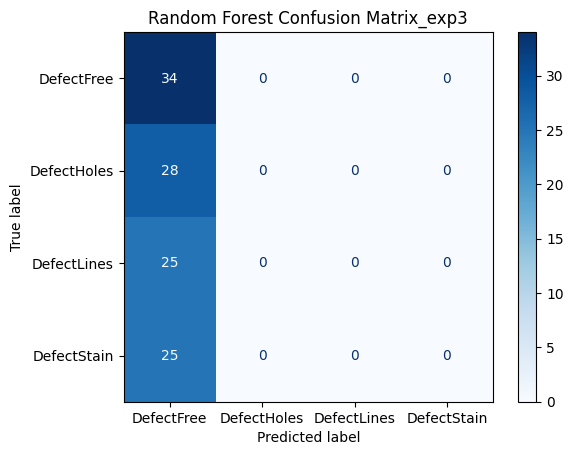

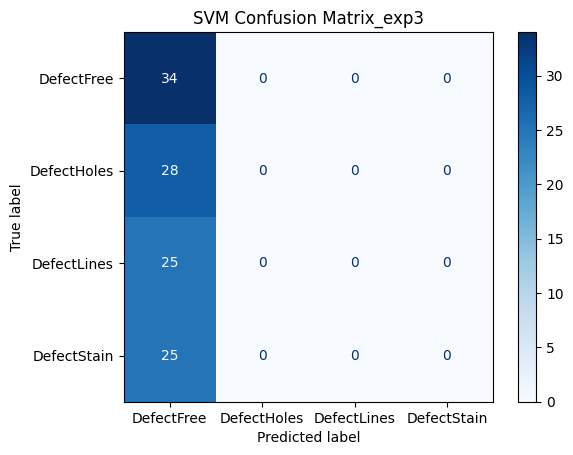

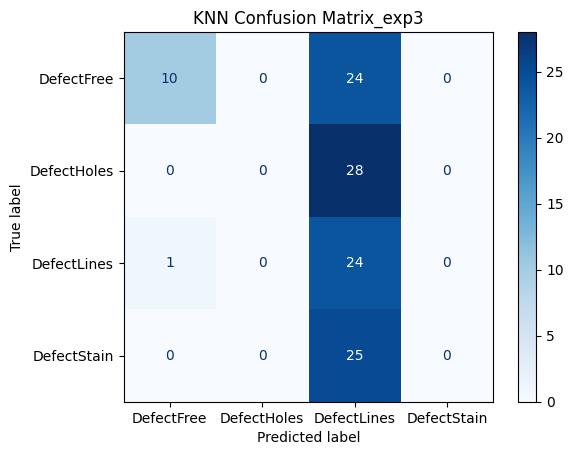

In [16]:

# === Evaluation with Confusion Matrix ===
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')

plot_confusion_matrix(y_test, y_pred_rf_test, "Random Forest Confusion Matrix_exp3")
plot_confusion_matrix(y_test, y_pred_svm_test, "SVM Confusion Matrix_exp3")
plot_confusion_matrix(y_test, y_pred_knn_test, "KNN Confusion Matrix_exp3")